In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import arch
from arch import arch_model
from arch.univariate import GARCH
from scipy.stats import invweibull
from scipy.optimize import rosen, differential_evolution
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from empyrical.stats import conditional_value_at_risk
import datetime

In [73]:
# load the data

rate_df = pd.read_csv("C:/Users/severusbot/Documents/AMS_517/Frechet_Model/VIX_History.csv")


rate_df = rate_df[['DATE', 'OPEN', 'CLOSE']]
rate_df['OPEN'] = pd.to_numeric(rate_df['OPEN'])
rate_df['CLOSE'] = pd.to_numeric(rate_df['CLOSE'])
rate_df['DATE'] = pd.to_datetime(rate_df['DATE'])
rate_df['LOSS'] = (rate_df['CLOSE'] - rate_df['OPEN']) / rate_df['OPEN']
rate_df = rate_df[['DATE', 'LOSS']]

# find the max loss of each hour

rate_df.set_index('DATE', inplace = True)

maxloss_df = -rate_df.resample('W').min().dropna()
maxloss_df = maxloss_df[(maxloss_df.T != 0).any()]
display(maxloss_df)

# check for NaN

maxloss_df.isnull().values.any()



,LOSS
DATE,
1992-01-05,0.037583
1992-01-12,0.052709
1992-01-19,0.054593
1992-01-26,0.045040
1992-02-02,-0.032198
...,...
2022-03-20,0.099608
2022-03-27,0.082169
2022-04-03,0.113369


False

In [74]:
# fit the frechet distribution using 500 data points

global_shape,global_loc,global_scale = invweibull.fit(maxloss_df['LOSS'])
1/global_shape,global_loc,global_scale



C:\Users\severusbot\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\severusbot\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1797: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


(0.005607669787637813, -5.4448501452637075, 5.4895798921203145)

In [75]:
# Time varying parameters

In [76]:
# we will use 250 samples

time_df = maxloss_df.copy()
time_df['Scale'] = np.nan
time_df['Shape'] = np.nan
time_df['Location'] = global_loc

def fit_invweibull(val):

    shape, loc, scale = invweibull.fit(val, floc = global_loc)
    return 1/shape, loc, scale

for x in range(1, 251):
    time_df.iloc[250+x, 2], loc, time_df.iloc[250+x, 1] = fit_invweibull(maxloss_df['LOSS'][:250+x])

time_df = time_df.bfill(axis = 'rows')
time_df = time_df.reset_index()

#time_df

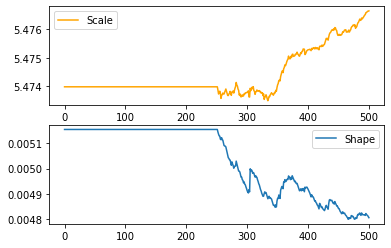

In [77]:
fig,ax = plt.subplots(2,1)

ax[1].plot(time_df['Shape'].values, label='Shape')
ax[0].plot(time_df['Scale'].values, label='Scale',color='orange') # flip returns to view
ax[0].legend()
ax[1].legend()

In [78]:
# estimating coefficients using the training set
temp_df = time_df.copy(deep = True)
temp_df = temp_df.dropna()

exog = -temp_df['LOSS'][249:-1].values

mod = AutoReg(np.log(temp_df['Shape'][250:].values), 1, trend = 'c', exog = np.exp(exog))
res = mod.fit()
shape_params = res.params
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  251
Model:                   AutoReg-X(1)   Log Likelihood                1375.469
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Thu, 14 Apr 2022   AIC                            -13.810
Time:                        21:58:54   BIC                            -13.753
Sample:                             1   HQIC                           -13.787
                                  251                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0368      0.021      1.787      0.074      -0.004       0.077
y.L1           0.9972      0.004    263.195      0.000       0.990       1.005
x1            -0.0544      0.002    -25.259      0.0

C:\Users\severusbot\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


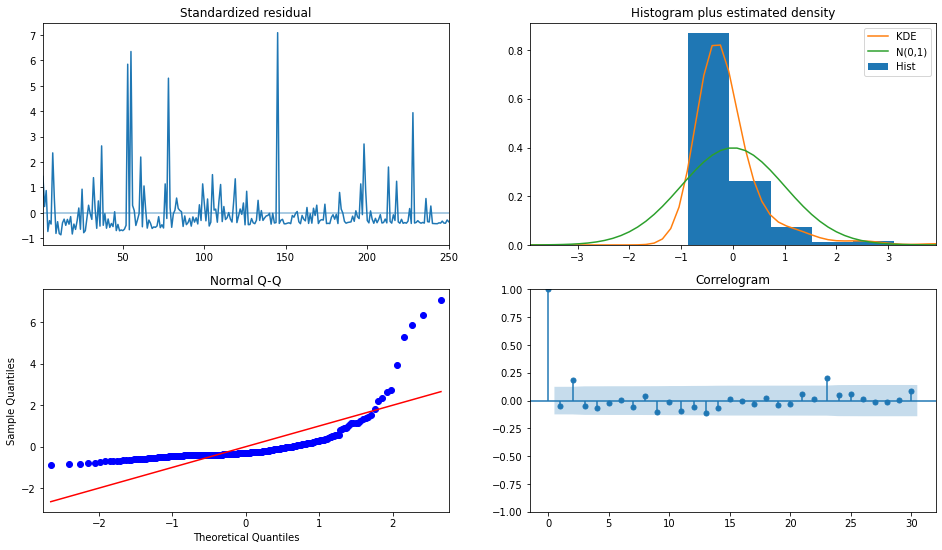

In [79]:
fig = plt.figure(figsize = (16, 9))
fig = res.plot_diagnostics(fig = fig, lags = 30)

In [80]:
exog = -temp_df['LOSS'][224:-1].values

mod = AutoReg(np.log(temp_df['Scale'][225:].values), 1, trend = 'c', exog = np.exp(exog))
res = mod.fit()
scale_params = res.params
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  276
Model:                   AutoReg-X(1)   Log Likelihood                2942.709
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Thu, 14 Apr 2022   AIC                            -24.210
Time:                        21:58:54   BIC                            -24.158
Sample:                             1   HQIC                           -24.189
                                  276                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0026      0.003      0.802      0.423      -0.004       0.009
y.L1           0.9987      0.002    532.284      0.000       0.995       1.002
x1            -0.0003   1.12e-05    -29.814      0.0

C:\Users\severusbot\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


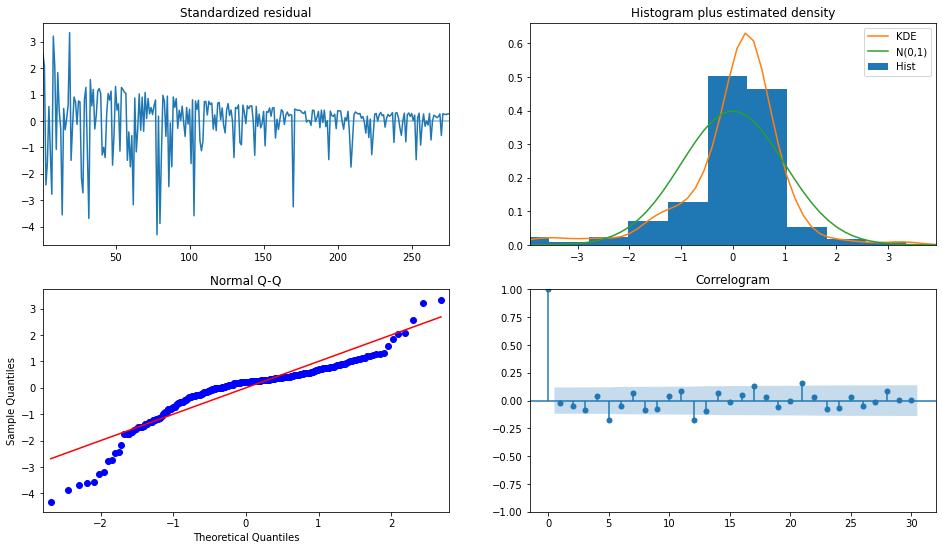

In [81]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

In [82]:
# Using the test data set

#pd.set_option('display.max_rows', None)
cvar1=pd.Series([])
cvar2=pd.Series([])
cvar3=pd.Series([])

counter = 0

for x,row in time_df.iterrows():
    if not np.isnan(row['Shape']) and not np.isnan(row['Scale']) :
        counter=counter+1
        cvar1=cvar1.append(pd.Series([np.nan],index=[x]))
        cvar2=cvar2.append(pd.Series([np.nan],index=[x]))
        cvar3=cvar3.append(pd.Series([np.nan],index=[x]))
        continue
    #print(np.exp(shape_params[0]+shape_params[1]*np.log(time_df['Shape'][counter-1])+shape_params[2]*np.exp(-time_df['Loss'][counter-1]) ))

    time_df.at[x, 'Shape'] = np.exp(shape_params[0]+shape_params[1]*np.log(time_df['Shape'][counter-1])+shape_params[2]*np.exp(-time_df['LOSS'][counter-1]) )# walk forward from our eqns
    time_df.at[x, 'Scale'] = np.exp(scale_params[0]+scale_params[1]*np.log(time_df['Scale'][counter-1])+scale_params[2]*np.exp(-time_df['LOSS'][counter-1]) )# walk forward 
    
    # empirical cvars for each fitted period outside of train set #1 
    cvar1=cvar1.append(pd.Series([conditional_value_at_risk(time_df['LOSS'][:counter],0.90)],index=[x]))
    cvar2=cvar2.append(pd.Series([conditional_value_at_risk(time_df['LOSS'][:counter],0.95)],index=[x]))
    cvar3=cvar3.append(pd.Series([conditional_value_at_risk(time_df['LOSS'][:counter],0.99)],index=[x]))
    
    counter=counter+1
time_df['cvar_0.90']=cvar1
time_df['cvar_0.95']=cvar2
time_df['cvar_0.99']=cvar3
    
#time_df

<ipython-input-82-c7f4e5cece83>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar1=pd.Series([])
<ipython-input-82-c7f4e5cece83>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar2=pd.Series([])
<ipython-input-82-c7f4e5cece83>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar3=pd.Series([])


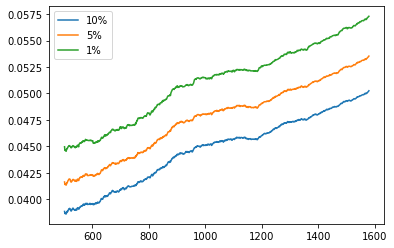

In [83]:
plt.plot(time_df['cvar_0.90'],label='10%')
plt.plot(time_df['cvar_0.95'],label='5%')
plt.plot(time_df['cvar_0.99'],label='1%')
plt.legend()

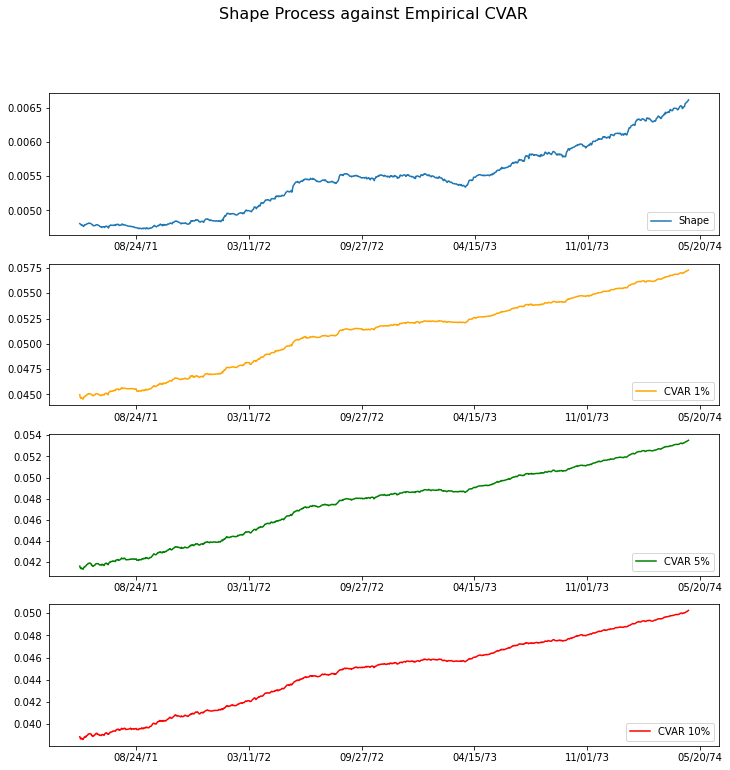

In [106]:
fig,ax = plt.subplots(4,1,figsize=(12,12))

fig.suptitle("Shape Process against Empirical CVAR",fontsize=16)
ax[0].plot(time_df['Shape'][500:], label='Shape')
ax[1].plot(time_df['cvar_0.99'][500:], label='CVAR 1%',color='orange') 
ax[2].plot(time_df['cvar_0.95'][500:], label='CVAR 5%',color='green') 
ax[3].plot(time_df['cvar_0.90'][500:], label='CVAR 10%',color='red') 
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[2].legend(loc='lower right')
ax[3].legend(loc='lower right')
ax[0].xaxis.set_major_formatter(DateFormatter("%D"))
ax[1].xaxis.set_major_formatter(DateFormatter("%D"))
ax[2].xaxis.set_major_formatter(DateFormatter("%D"))
ax[3].xaxis.set_major_formatter(DateFormatter("%D"))

In [85]:
print(np.corrcoef(time_df['Shape'][501:],time_df['cvar_0.90'][501:]))
print(np.corrcoef(time_df['Shape'][501:],time_df['cvar_0.95'][501:]))
print(np.corrcoef(time_df['Shape'][501:],time_df['cvar_0.99'][501:]))

[[1.         0.97368299]
 [0.97368299 1.        ]]
[[1.         0.97563017]
 [0.97563017 1.        ]]
[[1.         0.97762279]
 [0.97762279 1.        ]]


In [89]:
am = arch_model(maxloss_df['LOSS'][750:],rescale=True)  # generate 
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1160430.3547353167
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1014.643772862321
Iteration:      3,   Func. Count:     23,   Neg. LLF: 408.2909849190616
Iteration:      4,   Func. Count:     29,   Neg. LLF: 384.9280559174272
Iteration:      5,   Func. Count:     34,   Neg. LLF: 384.81340293937797
Iteration:      6,   Func. Count:     40,   Neg. LLF: 384.59860418111884
Iteration:      7,   Func. Count:     46,   Neg. LLF: 384.5597223802545
Iteration:      8,   Func. Count:     51,   Neg. LLF: 384.5589290668665
Iteration:      9,   Func. Count:     56,   Neg. LLF: 384.55891163340766
Iteration:     10,   Func. Count:     61,   Neg. LLF: 384.5589093855288
Iteration:     11,   Func. Count:     65,   Neg. LLF: 384.55890938552795
Optimization terminated successfully    (Exit mode 0)
            Current function value: 384.5589093855288
            Iterations: 11
            Function evaluations: 65
            Gradient evaluation